### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.metrics import accuracy_score
import os

### Data exploration

In [4]:
attrdata = pd.read_csv("Table_1.csv")

### Print the first 5 rows in the data set

In [6]:
attrdata.head()

,table id,name,phone number,Location,Emp. Group,Function,Gender,Tenure,Tenure Grp.,Experience (YY.MM),Marital Status,Age in YY.,Hiring Source,Promoted/Non Promoted,Job Role Match,Stay/Left
0,1,sid,9876544345,Pune,B2,Operation,Male,0.00,< =1,6.08,Single,27.12,Direct,Non Promoted,Yes,Left
1,2,sid,9876544345,Noida,B7,Support,Male,0.00,< =1,13.00,Marr.,38.08,Direct,Promoted,No,Stay
2,3,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,16.05,Marr.,36.04,Direct,Promoted,Yes,Stay
3,4,sid,9876544345,Noida,B2,Operation,Male,0.01,< =1,6.06,Marr.,32.07,Direct,Promoted,Yes,Stay
4,5,sid,9876544345,Lucknow,B2,Operation,Male,0.00,< =1,7.00,Marr.,32.05,Direct,Non Promoted,Yes,Stay


### Dropping the index column

In [ ]:
attrdata.drop(0,inplace=True)


### checking for null values

In [10]:
attrdata.isnull().sum()

table id                 0
name                     0
phone number             0
Location                 0
Emp. Group               0
Function                 0
Gender                   0
Tenure                   0
Tenure Grp.              0
Experience (YY.MM)       4
Marital Status           0
Age in YY.               0
Hiring Source            0
Promoted/Non Promoted    0
Job Role Match           2
Stay/Left                0
dtype: int64

### print the rows which contain null values

In [13]:
print(attrdata.loc[attrdata.isnull().any(axis=1)])

     table id    name  phone number    Location Emp. Group   Function Gender   \
28         29  shruti    9876544345   Hyderabad         B1  Operation    Male   
85         86  shruti    9876544345   Hyderabad         B1  Operation  Female   
131       132   Dwane    9876544345   Hyderabad         B1  Operation    Male   
893       894   Rahul    9876544345   Hyderabad         B1  Operation  Female   
895       896   Rahul    9876544345  Vijayawada         B1  Operation    Male   
899       900   Rahul    9876544345  Vijayawada         B1  Operation  Female   

     Tenure Tenure Grp.  Experience (YY.MM) Marital Status  Age in YY.  \
28     0.03        < =1                 NaN           NTBD       32.08   
85     0.07        < =1                 NaN           NTBD       24.03   
131    0.08        < =1                 NaN           NTBD       23.09   
893    0.06        < =1                 NaN           NTBD       30.00   
895    0.03        < =1                0.03         Single    

In [19]:
attrdata.dropna(axis=0,inplace=True)

In [20]:
attrdata.isnull().sum()

table id                 0
name                     0
phone number             0
Location                 0
Emp. Group               0
Function                 0
Gender                   0
Tenure                   0
Tenure Grp.              0
Experience (YY.MM)       0
Marital Status           0
Age in YY.               0
Hiring Source            0
Promoted/Non Promoted    0
Job Role Match           0
Stay/Left                0
dtype: int64

In [22]:
attrdata.shape

(895, 16)

### Let’s explore all the categorical values and visualize them

In [29]:
gender_dict = attrdata["Gender "].value_counts()

In [30]:
gender_dict

Male      655
Female    234
other       6
Name: Gender , dtype: int64

In [31]:
promoted_dict = attrdata["Promoted/Non Promoted"].value_counts()
promoted_dict

Promoted        457
Non Promoted    438
Name: Promoted/Non Promoted, dtype: int64

In [32]:
func_dict = attrdata["Function"].value_counts()
func_dict

Operation    831
Support       52
Sales         12
Name: Function, dtype: int64

In [33]:
Hiring_dict = attrdata["Hiring Source"].value_counts()
Hiring_dict

Direct               708
Agency               116
Employee Referral     71
Name: Hiring Source, dtype: int64

In [34]:
Marital_dict = attrdata["Marital Status"].value_counts()
print(Marital_dict)

Single    533
Marr.     356
Div.        2
NTBD        2
Sep.        2
Name: Marital Status, dtype: int64


In [35]:
Emp_dict = attrdata["Emp. Group"].value_counts()
Emp_dict['other group'] = 1
print(Emp_dict)

B1             537
B2             275
B3              59
B0               8
B4               7
B5               4
B7               2
B6               1
C3               1
D2               1
other group      1
Name: Emp. Group, dtype: int64


In [36]:
job_dict = attrdata["Job Role Match"].value_counts()
job_dict

Yes    480
No     415
Name: Job Role Match, dtype: int64

In [37]:
tenure_dict = attrdata["Tenure Grp."].value_counts()
print(tenure_dict)

> 1 & < =3    626
< =1          269
Name: Tenure Grp., dtype: int64


In [38]:
location_dict = attrdata["Location"].value_counts()
print(location_dict)

Chennai       255
Noida         236
Bangalore     210
Hyderabad      62
Pune           55
Madurai        29
Lucknow        20
Nagpur         14
Vijayawada      6
Mumbai          4
Gurgaon         3
Kolkata         1
Name: Location, dtype: int64


<AxesSubplot: title={'center': 'Count of different gender'}>

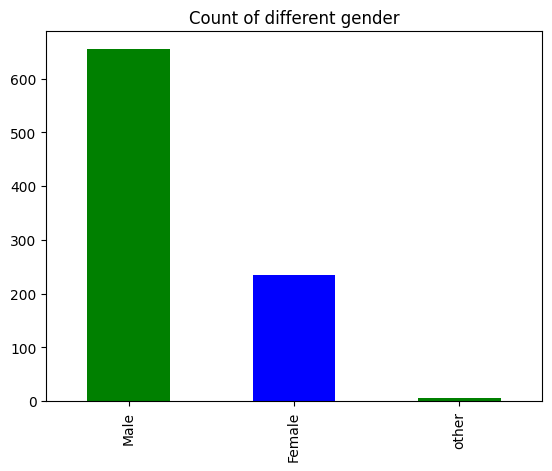

In [43]:
attrdata['Gender '].value_counts().plot(kind='bar',color=['green','blue'],title="Count of different gender")

(array([0, 1, 2]),
 [Text(0, 0, 'Female'), Text(1, 0, 'Male'), Text(2, 0, 'other')])

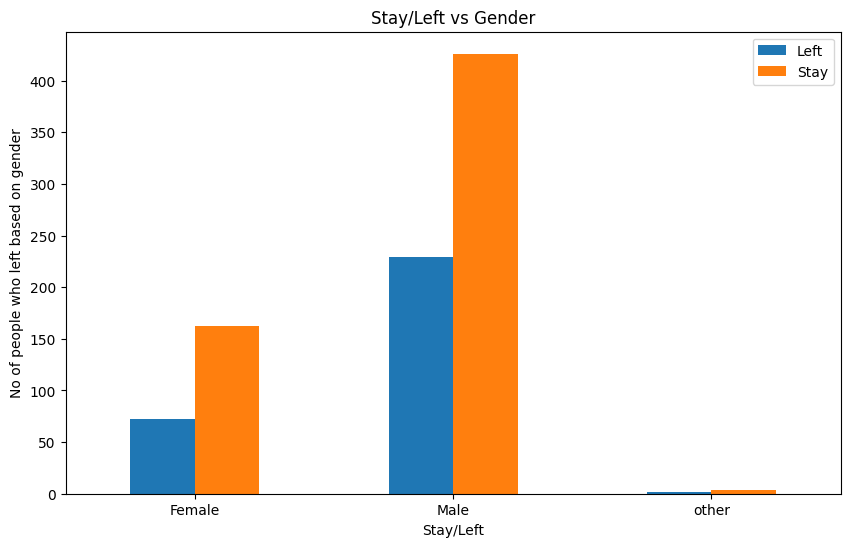

In [46]:
#Create a plot for crosstab

pd.crosstab(attrdata['Gender '],attrdata['Stay/Left']).plot(kind="bar",figsize=(10,6))
plt.title("Stay/Left vs Gender")
plt.xlabel("Stay/Left")
plt.ylabel("No of people who left based on gender")
plt.legend(["Left","Stay"])
plt.xticks(rotation=0)

### Data cleaning


In [47]:
location_dict = attrdata["Location"].value_counts()
print(location_dict)

location_dict_new = {
    'Chennai':       7,
    'Noida':         6,
    'Bangalore':     5,
    'Hyderabad':     4,
    'Pune':          3,
    'Madurai':       2,
    'Lucknow':       1,
    'other place':   0,
}

print(location_dict_new)

Chennai       255
Noida         236
Bangalore     210
Hyderabad      62
Pune           55
Madurai        29
Lucknow        20
Nagpur         14
Vijayawada      6
Mumbai          4
Gurgaon         3
Kolkata         1
Name: Location, dtype: int64
{'Chennai': 7, 'Noida': 6, 'Bangalore': 5, 'Hyderabad': 4, 'Pune': 3, 'Madurai': 2, 'Lucknow': 1, 'other place': 0}


In [48]:
def location(x):
    if str(x) in location_dict_new.keys():
        return location_dict_new[str(x)]
    else:
        return location_dict_new['other place']
    
data_l = attrdata["Location"].apply(location)
attrdata['New Location'] = data_l
attrdata.head()

,table id,name,phone number,Location,Emp. Group,Function,Gender,Tenure,Tenure Grp.,Experience (YY.MM),Marital Status,Age in YY.,Hiring Source,Promoted/Non Promoted,Job Role Match,Stay/Left,New Location
1,2,sid,9876544345,Noida,B7,Support,Male,0.00,< =1,13.00,Marr.,38.08,Direct,Promoted,No,Stay,6
2,3,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,16.05,Marr.,36.04,Direct,Promoted,Yes,Stay,5
3,4,sid,9876544345,Noida,B2,Operation,Male,0.01,< =1,6.06,Marr.,32.07,Direct,Promoted,Yes,Stay,6
4,5,sid,9876544345,Lucknow,B2,Operation,Male,0.00,< =1,7.00,Marr.,32.05,Direct,Non Promoted,Yes,Stay,1
5,6,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,9.01,Marr.,39.09,Direct,Promoted,No,Stay,5


In [49]:
gen = pd.get_dummies(attrdata["Function"])
gen

,Operation,Sales,Support
1,0,0,1
2,1,0,0
3,1,0,0
4,1,0,0
5,1,0,0
...,...,...,...
896,1,0,0
897,1,0,0
898,1,0,0
900,1,0,0


In [50]:
hr = pd.get_dummies(attrdata["Hiring Source"])
hr.head()

,Agency,Direct,Employee Referral
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
5,0,1,0


In [ ]:
# Marital Status
def Mar(x):
    if str(x) in Marital_dict.keys() and Marital_dict[str(x)] > 100:
        return str(x)
    else:
        return 'other status'
    
data_l = attrdata["Marital Status"].apply(Mar)
attrdata['New Marital'] = data_l
attrdata.head()

In [54]:
Mr = pd.get_dummies(attrdata["New Marital"])
Mr.head()

,Marr.,Single,other status
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
5,1,0,0


In [55]:
#Promoted/Not Promoted
def Promoted(x):
    if x == 'Promoted':
        return int(1)
    else:
        return int(0)
    
data_l = attrdata["Promoted/Non Promoted"].apply(Promoted)
attrdata['New Promotion'] = data_l
attrdata.head()

,table id,name,phone number,Location,Emp. Group,Function,Gender,Tenure,Tenure Grp.,Experience (YY.MM),Marital Status,Age in YY.,Hiring Source,Promoted/Non Promoted,Job Role Match,Stay/Left,New Location,New Marital,New Promotion
1,2,sid,9876544345,Noida,B7,Support,Male,0.00,< =1,13.00,Marr.,38.08,Direct,Promoted,No,Stay,6,Marr.,1
2,3,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,16.05,Marr.,36.04,Direct,Promoted,Yes,Stay,5,Marr.,1
3,4,sid,9876544345,Noida,B2,Operation,Male,0.01,< =1,6.06,Marr.,32.07,Direct,Promoted,Yes,Stay,6,Marr.,1
4,5,sid,9876544345,Lucknow,B2,Operation,Male,0.00,< =1,7.00,Marr.,32.05,Direct,Non Promoted,Yes,Stay,1,Marr.,0
5,6,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,9.01,Marr.,39.09,Direct,Promoted,No,Stay,5,Marr.,1


In [56]:
# Employee Group
Emp_dict_new = {
    'B1': 4,
    'B2': 3,
    'B3': 2,
    'other group': 1,
}


def emp(x):
    if str(x) in Emp_dict_new.keys():
        return str(x)
    else:
        return 'other group'
    
data_l = attrdata["Emp. Group"].apply(emp)
attrdata['New EMP'] = data_l

emp = pd.get_dummies(attrdata["New EMP"])
attrdata.head()

,table id,name,phone number,Location,Emp. Group,Function,Gender,Tenure,Tenure Grp.,Experience (YY.MM),Marital Status,Age in YY.,Hiring Source,Promoted/Non Promoted,Job Role Match,Stay/Left,New Location,New Marital,New Promotion,New EMP
1,2,sid,9876544345,Noida,B7,Support,Male,0.00,< =1,13.00,Marr.,38.08,Direct,Promoted,No,Stay,6,Marr.,1,other group
2,3,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,16.05,Marr.,36.04,Direct,Promoted,Yes,Stay,5,Marr.,1,B3
3,4,sid,9876544345,Noida,B2,Operation,Male,0.01,< =1,6.06,Marr.,32.07,Direct,Promoted,Yes,Stay,6,Marr.,1,B2
4,5,sid,9876544345,Lucknow,B2,Operation,Male,0.00,< =1,7.00,Marr.,32.05,Direct,Non Promoted,Yes,Stay,1,Marr.,0,B2
5,6,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,9.01,Marr.,39.09,Direct,Promoted,No,Stay,5,Marr.,1,B3


In [57]:
#Job Role Match
def Job(x):
    if x == 'Yes':
        return int(1)
    else:
        return int(0)
    
data_l = attrdata["Job Role Match"].apply(Job)
attrdata['New Job Role Match'] = data_l
attrdata.head()

,table id,name,phone number,Location,Emp. Group,Function,Gender,Tenure,Tenure Grp.,Experience (YY.MM),...,Age in YY.,Hiring Source,Promoted/Non Promoted,Job Role Match,Stay/Left,New Location,New Marital,New Promotion,New EMP,New Job Role Match
1,2,sid,9876544345,Noida,B7,Support,Male,0.00,< =1,13.00,...,38.08,Direct,Promoted,No,Stay,6,Marr.,1,other group,0
2,3,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,16.05,...,36.04,Direct,Promoted,Yes,Stay,5,Marr.,1,B3,1
3,4,sid,9876544345,Noida,B2,Operation,Male,0.01,< =1,6.06,...,32.07,Direct,Promoted,Yes,Stay,6,Marr.,1,B2,1
4,5,sid,9876544345,Lucknow,B2,Operation,Male,0.00,< =1,7.00,...,32.05,Direct,Non Promoted,Yes,Stay,1,Marr.,0,B2,1
5,6,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,9.01,...,39.09,Direct,Promoted,No,Stay,5,Marr.,1,B3,0


In [58]:
# Gender
def Gen(x):
    if x in gender_dict.keys():
        return str(x)
    else:
        return 'other'
    
data_l = attrdata["Gender "].apply(Gen)
attrdata['New Gender'] = data_l
attrdata.head()

,table id,name,phone number,Location,Emp. Group,Function,Gender,Tenure,Tenure Grp.,Experience (YY.MM),...,Hiring Source,Promoted/Non Promoted,Job Role Match,Stay/Left,New Location,New Marital,New Promotion,New EMP,New Job Role Match,New Gender
1,2,sid,9876544345,Noida,B7,Support,Male,0.00,< =1,13.00,...,Direct,Promoted,No,Stay,6,Marr.,1,other group,0,Male
2,3,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,16.05,...,Direct,Promoted,Yes,Stay,5,Marr.,1,B3,1,Male
3,4,sid,9876544345,Noida,B2,Operation,Male,0.01,< =1,6.06,...,Direct,Promoted,Yes,Stay,6,Marr.,1,B2,1,Male
4,5,sid,9876544345,Lucknow,B2,Operation,Male,0.00,< =1,7.00,...,Direct,Non Promoted,Yes,Stay,1,Marr.,0,B2,1,Male
5,6,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,9.01,...,Direct,Promoted,No,Stay,5,Marr.,1,B3,0,Male


In [59]:
gend = pd.get_dummies(attrdata["New Gender"])
gend.head()

,Female,Male,other
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
5,0,1,0


In [60]:
tengrp = pd.get_dummies(attrdata["Tenure Grp."])
tengrp.head()

,< =1,> 1 & < =3
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0


In [61]:
dataset = pd.concat([attrdata, hr, Mr, emp, tengrp, gen, gend], axis = 1)

In [62]:
dataset

,table id,name,phone number,Location,Emp. Group,Function,Gender,Tenure,Tenure Grp.,Experience (YY.MM),...,B3,other group,< =1,> 1 & < =3,Operation,Sales,Support,Female,Male,other
1,2,sid,9876544345,Noida,B7,Support,Male,0.00,< =1,13.00,...,0,1,1,0,0,0,1,0,1,0
2,3,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,16.05,...,1,0,1,0,1,0,0,0,1,0
3,4,sid,9876544345,Noida,B2,Operation,Male,0.01,< =1,6.06,...,0,0,1,0,1,0,0,0,1,0
4,5,sid,9876544345,Lucknow,B2,Operation,Male,0.00,< =1,7.00,...,0,0,1,0,1,0,0,0,1,0
5,6,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,9.01,...,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,897,Rahul,9876544345,Vijayawada,B1,Operation,Male,0.03,< =1,0.03,...,0,0,1,0,1,0,0,0,1,0
897,898,Rahul,9876544345,Vijayawada,B1,Operation,Female,0.03,< =1,0.03,...,0,0,1,0,1,0,0,1,0,0
898,899,Rahul,9876544345,Vijayawada,B1,Operation,Female,0.03,< =1,0.03,...,0,0,1,0,1,0,0,1,0,0
900,901,Rahul,9876544345,Vijayawada,B1,Operation,Female,0.03,< =1,0.03,...,0,0,1,0,1,0,0,1,0,0


In [63]:
dataset.columns

Index(['table id', 'name', 'phone number', 'Location', 'Emp. Group',
       'Function', 'Gender ', 'Tenure', 'Tenure Grp.', 'Experience (YY.MM)',
       'Marital Status', 'Age in YY.', 'Hiring Source',
       'Promoted/Non Promoted', 'Job Role Match', 'Stay/Left', 'New Location',
       'New Marital', 'New Promotion', 'New EMP', 'New Job Role Match',
       'New Gender', 'Agency', 'Direct', 'Employee Referral', 'Marr.',
       'Single', 'other status', 'B1', 'B2', 'B3', 'other group', '< =1',
       '> 1 & < =3', 'Operation', 'Sales', 'Support', 'Female', 'Male',
       'other'],
      dtype='object')

In [64]:
dataset.drop(["table id", "name", "Marital Status","Promoted/Non Promoted","Function","Emp. Group","Job Role Match","Location"
              ,"Hiring Source","Gender ", 'Tenure', 'New Gender', 'New Marital', 'New EMP'],axis=1,inplace=True)

In [66]:
dataset1 = dataset.drop(['Tenure Grp.', 'phone number'], axis = 1)

In [68]:
dataset1

,Experience (YY.MM),Age in YY.,Stay/Left,New Location,New Promotion,New Job Role Match,Agency,Direct,Employee Referral,Marr.,...,B3,other group,< =1,> 1 & < =3,Operation,Sales,Support,Female,Male,other
1,13.00,38.08,Stay,6,1,0,0,1,0,1,...,0,1,1,0,0,0,1,0,1,0
2,16.05,36.04,Stay,5,1,1,0,1,0,1,...,1,0,1,0,1,0,0,0,1,0
3,6.06,32.07,Stay,6,1,1,0,1,0,1,...,0,0,1,0,1,0,0,0,1,0
4,7.00,32.05,Stay,1,0,1,0,1,0,1,...,0,0,1,0,1,0,0,0,1,0
5,9.01,39.09,Stay,5,1,0,0,1,0,1,...,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,0.03,24.06,Stay,0,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
897,0.03,21.09,Stay,0,0,1,0,1,0,0,...,0,0,1,0,1,0,0,1,0,0
898,0.03,22.02,Left,0,0,1,0,1,0,0,...,0,0,1,0,1,0,0,1,0,0
900,0.03,22.02,Stay,0,0,1,0,1,0,0,...,0,0,1,0,1,0,0,1,0,0


In [69]:
# Target 
"""
def Target(x):
    if x in "Stay":
        return False
    else:
        return True
    
data_l = dataset1["Stay/Left"].apply(Target)
dataset1['Stay/Left'] = data_l
"""
dataset1['Stay/Left'].head()

1    Stay
2    Stay
3    Stay
4    Stay
5    Stay
Name: Stay/Left, dtype: object

In [70]:
dataset1.to_csv("processed table new.csv")

In [71]:
dataset = pd.read_csv("processed table new.csv")
dataset = pd.DataFrame(dataset)
y = dataset["Stay/Left"]
X = dataset.drop("Stay/Left",axis=1)

Then, it creates two new variables y and X. The variable y is assigned the values of the "Stay/Left" column of the dataset DataFrame. The variable X is assigned the DataFrame resulting from the removal of the "Stay/Left" column from the dataset DataFrame using the drop() method with the axis=1 argument.

This code is splitting the dataset into two parts: one for the target variable and one for the features. The target variable 'y' will be used for prediction, and the feature dataset 'X' will be used for training the model. The drop() method is used to remove the column "Stay/Left" from the dataset as it is the target variable and it should not be included in the feature dataset.

This is a common approach to split the data into features and target variable prior to training a machine learning model. It separates the dependent variable which we want to predict and the independent variables which are used to make predictions.

## Splitting data - Train test split

In [72]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)

train_test_split() function from the sklearn.model_selection module to split the feature dataset X and the target variable y into training and testing sets. The function takes four arguments:

X: The feature dataset
y: The target variable
test_size: The proportion of the dataset to include in the test split. In this case, it is set to 0.2, so 20% of the data will be used for testing and 80% for training.
random_state : this is used to set a seed value. When you set a seed value, it initializes the random number generator, so that you can get the same random numbers every time you call the function.
The train_test_split() function returns four objects: X_train, X_test, y_train, and y_test which are the training sets for features and target variable and the testing sets for features and target variable respectively. The X_train and y_train will be used to train the model and the X_test and y_test will be used to evaluate the performance of the model.

This approach is used in machine learning to evaluate the performance of the model by testing it on unseen data. It is a good practice to test the model on unseen data because it gives an estimate of the performance of the model on unseen data, which is more realistic as it is more likely that the model will be used on unseen data in real-world applications.

In [79]:
y_test

881    Left
675    Left
238    Stay
328    Left
539    Stay
       ... 
623    Stay
89     Stay
615    Stay
760    Stay
384    Stay
Name: Stay/Left, Length: 179, dtype: object

### Model Development

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC

In [99]:
lr=LogisticRegression(C = 0.1, random_state = 42, solver = 'liblinear')
dt=DecisionTreeClassifier()
rm=RandomForestClassifier()
gnb=GaussianNB()
knn = KNeighborsClassifier(n_neighbors=3)
svm = SVC(kernel='linear')

### Now, from one block of code, we will check the accuracy of all the model

In [109]:
for a,b in zip([lr,dt,knn,svm,rm,gnb],["Logistic Regression","Decision Tree","KNN","SVM","Random Forest","Naive Bayes"]):
    a.fit(X_train,y_train)
    prediction=a.predict(X_train)
    y_pred=a.predict(X_test)
    score1=accuracy_score(y_train,prediction)
    score=accuracy_score(y_test,y_pred)
    msg1="[%s] training data accuracy is : %f" % (b,score1)
    msg2="[%s] test data accuracy is : %f" % (b,score)
    print(msg1)
    print(msg2)

[Logistic Regression] training data accuracy is : 0.891061
[Logistic Regression] test data accuracy is : 0.877095
[Decision Tree] training data accuracy is : 1.000000
[Decision Tree] test data accuracy is : 0.849162
[KNN] training data accuracy is : 0.804469
[KNN] test data accuracy is : 0.586592
[SVM] training data accuracy is : 0.878492
[SVM] test data accuracy is : 0.865922
[Random Forest] training data accuracy is : 1.000000
[Random Forest] test data accuracy is : 0.899441
[Naive Bayes] training data accuracy is : 0.870112
[Naive Bayes] test data accuracy is : 0.826816


### Different Model Scores (accuracy)

In [114]:
model_scores={'Logistic Regression':lr.score(X_test,y_test),
             'KNN classifier':knn.score(X_test,y_test),
             'Support Vector Machine':svm.score(X_test,y_test),
             'Random forest':rm.score(X_test,y_test),
              'Decision tree':dt.score(X_test,y_test),
              'Naive Bayes':gnb.score(X_test,y_test)
             }


In [115]:
model_scores

{'Logistic Regression': 0.8770949720670391,
 'KNN classifier': 0.5865921787709497,
 'Support Vector Machine': 0.8659217877094972,
 'Random forest': 0.8994413407821229,
 'Decision tree': 0.8491620111731844,
 'Naive Bayes': 0.8268156424581006}

In [116]:
#Based on accuracy,model comparison
model_compare=pd.DataFrame(model_scores,index=['accuracy'])
model_compare

,Logistic Regression,KNN classifier,Support Vector Machine,Random forest,Decision tree,Naive Bayes
accuracy,0.877095,0.586592,0.865922,0.899441,0.849162,0.826816


<AxesSubplot: >

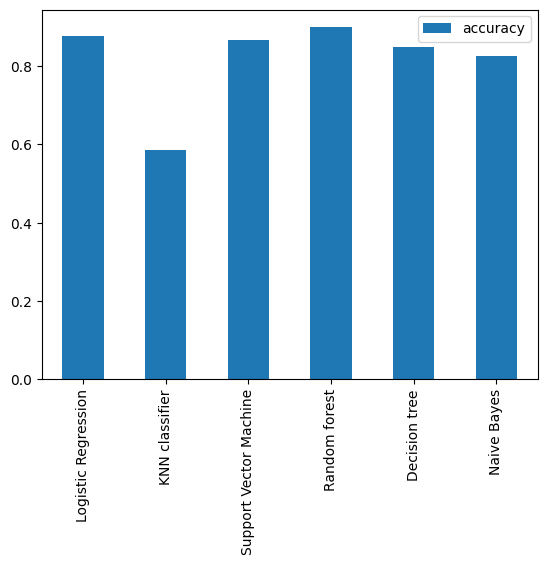

In [123]:
model_compare.T.plot(kind="bar")

<AxesSubplot: >

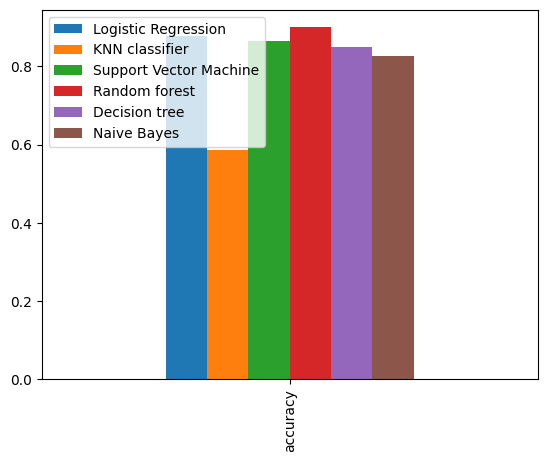

In [124]:
model_compare.plot(kind='bar') # (Not transposing the legends and y axis)

### Feature Importance

In [125]:
# These coef's tell how much and in what way did each one of it contribute to predicting the target variable
# Logistic regression

feature_dict=dict(zip(dataset.columns,list(lr.coef_[0])))
feature_dict

#This is a type of Model driven Exploratory data analysis

{'Unnamed: 0': -0.00036963862225066466,
 'Experience (YY.MM)': 0.13976826902383124,
 'Age in YY.': -0.019622030186639935,
 'Stay/Left': 0.024627352532592527,
 'New Location': 0.09666512065143482,
 'New Promotion': 2.7533361396404437,
 'New Job Role Match': -0.31312348489513964,
 'Agency': -0.020270885156543562,
 'Direct': 0.20478720815025309,
 'Employee Referral': 0.3879631877962489,
 'Marr.': -0.5042922677776501,
 'Single': -0.012278081920032942,
 'other status': -0.22031197154661722,
 'B1': 0.17649315192429732,
 'B2': -0.0936796585075568,
 'B3': 0.008891316228442586,
 'other group': -0.12993373247617745,
 '< =1': 0.0013265705747396578,
 '> 1 & < =3': -0.059494841514828894,
 'Operation': -0.018200464251064422,
 'Sales': -0.050911856135540584,
 'Support': 0.12249364800076454,
 'Female': -0.1951606022808629,
 'Male': -0.05594020762133034}

<AxesSubplot: title={'center': 'Feature Importance'}>

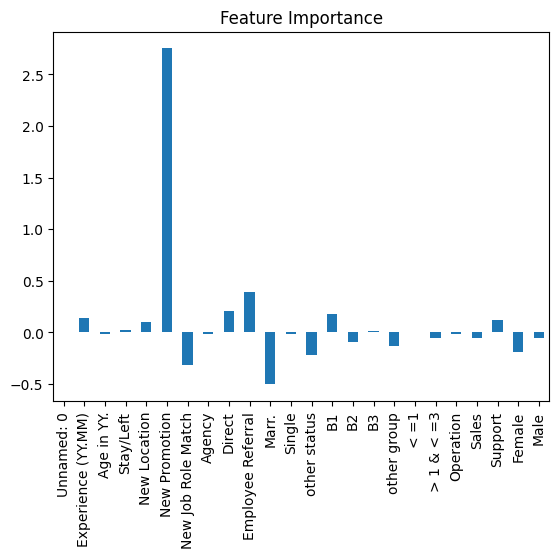

In [126]:
#Visualize feature importance

feature_df=pd.DataFrame(feature_dict,index=[0])
feature_df.T.plot(kind="bar",legend=False,title="Feature Importance")

### Saving the model 

In [127]:
# Logistic Regression model because it has best accuracy as well it is neither overfitted nor underfitted

model = lr.fit(X_train,y_train)

import pickle
# save the model to disk
filename = 'finalized_model_new.pickle'
pickle.dump(model, open(filename, 'wb'))